In [1]:
import tensorflow as tf
# tf.enable_eager_execution()
import src.infovae as infovae
import src.mri as mri

import numpy as np
import matplotlib.pyplot as plt

/home/act65/anaconda3/envs/mri/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/MNIST_data/", one_hot=False)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /tmp/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
with tf.variable_scope('s'):

    nn = infovae.InfoVAE(8, 64, 4)
    inputs = tf.placeholder(shape=[None, 32, 32, 1], dtype=tf.float32)

    y = nn(inputs)
    d = int(0.5*32*32*1)
    f = mri.MRI(N=d, stddev=0.0001)

In [4]:
def construct_loss(r, y, coeffs):
    p = nn.estimate_density(r)
    recon = nn(r)
    h = f(r)
    recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(h - y), axis=1))
    prior_loss = tf.reduce_mean(tf.reduce_sum(tf.square(nn.h[:,:,:,:8]), axis=1)) 
#     prior_loss =  tf.reduce_mean(1 - p)
    tv_loss = tf.reduce_mean(tf.image.total_variation(r))

    agg_loss = (coeffs[0]*recon_loss+
                coeffs[1]*prior_loss+
                coeffs[2]*tv_loss)
    return agg_loss

In [5]:
saver = tf.train.Saver(nn.encoder.variables + nn.decoder.variables)
model_path = '/media/act65/640a4914-fb27-4b69-acc6-2a2d569c900b/infovae/17'

def reconstruct(x, N, coeffs, lr=0.1):
    iters = N//10
    global_step = tf.train.get_or_create_global_step()
    stddev = tf.train.exponential_decay(0.1,global_step,iters//5,0.5)
    
    y = f(inputs)
    r = tf.Variable(tf.zeros_like(x)) #tf.nn.sigmoid(tf.random_normal(tf.shape(x))))
    loss = construct_loss(r, y, coeffs)
    train_step = tf.train.AdamOptimizer(lr).minimize(loss, var_list=[r], global_step=global_step)
    op = r.assign_add(tf.random_normal(shape=tf.shape(r), stddev=stddev))
    train_step = tf.group(*[train_step, op])
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, tf.train.latest_checkpoint(model_path))
        
        plt.figure(figsize=(16,8))
        for i in range(N):
            sess.run(train_step, feed_dict={inputs: x})
            
            if i % iters == 0:
                recon, L = sess.run([r, loss], feed_dict={inputs: x})
                print('\r{}'.format(L),end='',flush=True)
                plt.subplot(2,5,i//iters+1)
                plt.imshow(recon[0,:,:,0].reshape((32,32)), cmap='gray', interpolation='nearest')
                plt.axis('off')
        R = sess.run(r)
    return R

INFO:tensorflow:Restoring parameters from /media/act65/640a4914-fb27-4b69-acc6-2a2d569c900b/infovae/17/infovae_saver.ckpt


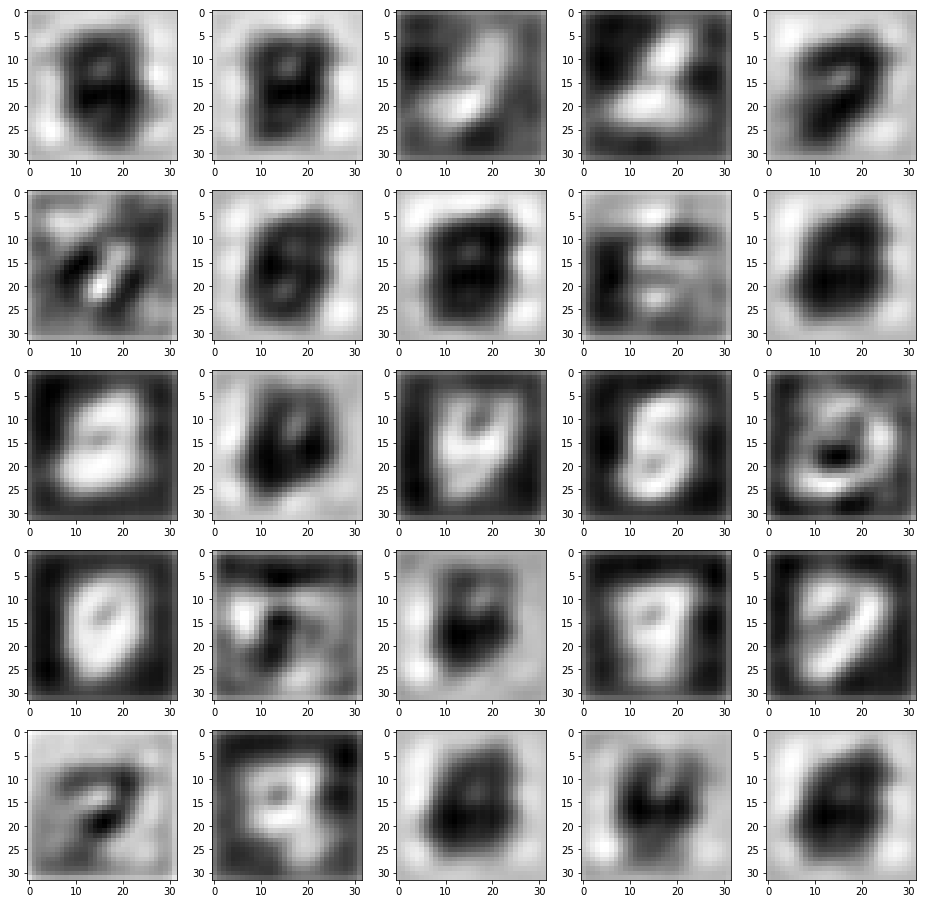

In [6]:
# check the restored params
with tf.variable_scope('scope'):
    r = nn.decoder(tf.random_normal(shape=tf.shape(nn.z)))
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint(model_path))
        recon = sess.run(r, feed_dict={inputs: infovae.InfoVAE.preprocess(mnist.train.images[0:25, ...])})

plt.figure(figsize=(16,16))        
for i in range(len(recon)):
    plt.subplot(5,5,i+1)
    plt.imshow(recon[i,:,:,0].reshape((32,32)), cmap='gray', interpolation='nearest')

INFO:tensorflow:Restoring parameters from /media/act65/640a4914-fb27-4b69-acc6-2a2d569c900b/infovae/17/infovae_saver.ckpt
0.05640988424420357

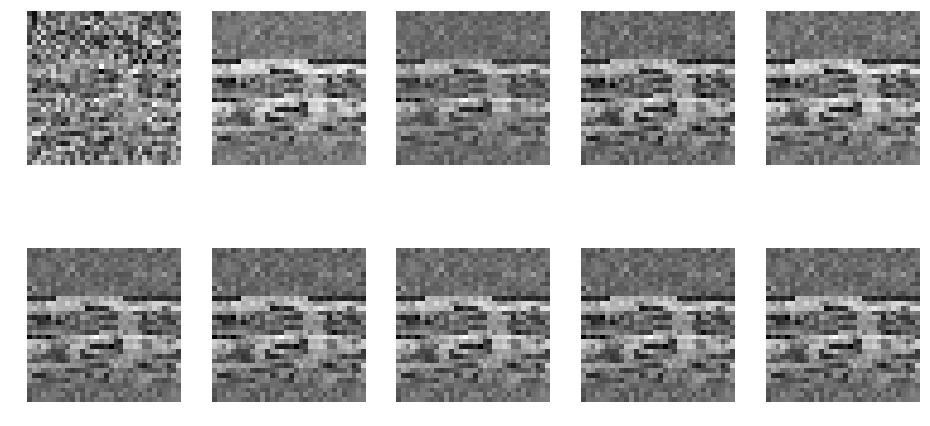

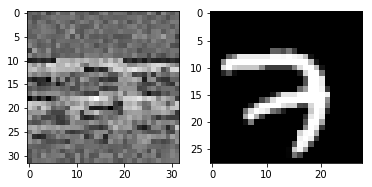

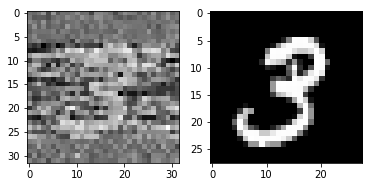

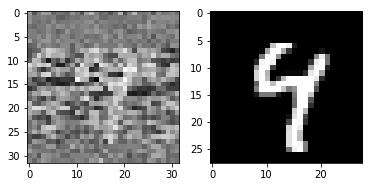

In [7]:
x = infovae.InfoVAE.preprocess(mnist.train.images[0:3, ...])
recon = reconstruct(x, 100, coeffs=[1,0,0,0])  # no regularisation, just the data

for i in range(3):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(recon[i, :, :, 0], interpolation='nearest', cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mnist.train.images[i].reshape((28,28)), interpolation='nearest', cmap='gray')

INFO:tensorflow:Restoring parameters from /media/act65/640a4914-fb27-4b69-acc6-2a2d569c900b/infovae/17/infovae_saver.ckpt
2.5869674118439434e-06

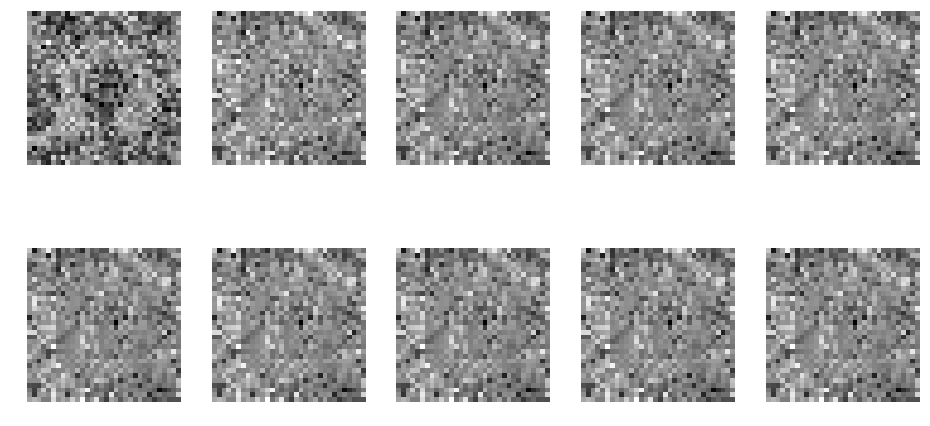

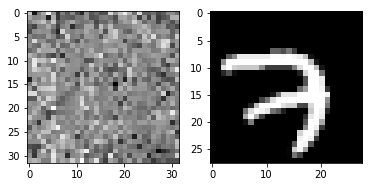

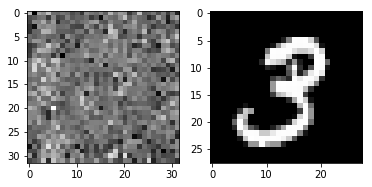

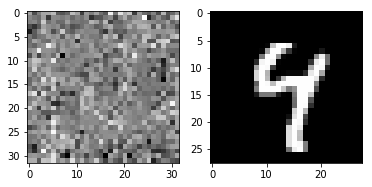

In [8]:
x = infovae.InfoVAE.preprocess(mnist.train.images[0:3, ...])
recon = reconstruct(x, 100, coeffs=[0,1,0], lr=0.1)  # learned prior

for i in range(3):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(recon[i, :, :, 0], interpolation='nearest', cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mnist.train.images[i].reshape((28,28)), interpolation='nearest', cmap='gray')

INFO:tensorflow:Restoring parameters from /media/act65/640a4914-fb27-4b69-acc6-2a2d569c900b/infovae/15/infovae_saver.ckpt
0.34958934783935547

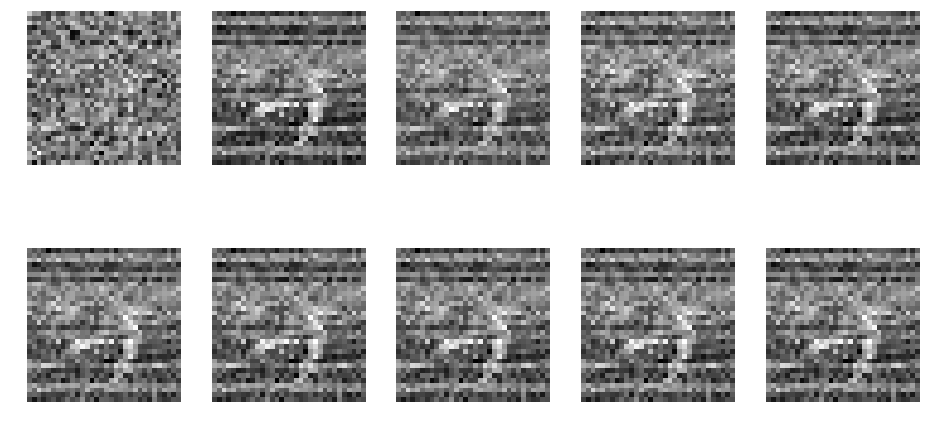

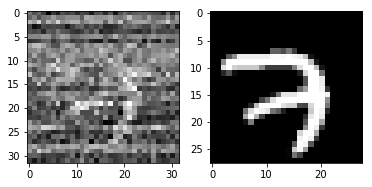

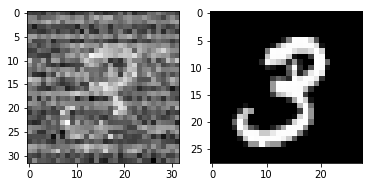

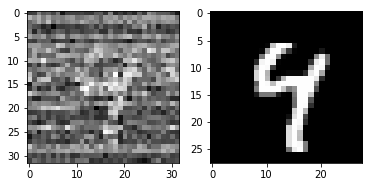

In [32]:
recon = reconstruct(x, 100, coeffs=[1,1,0])  # learned prior and recon

for i in range(3):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(recon[i, :, :, 0], interpolation='nearest', cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mnist.train.images[i].reshape((28,28)), interpolation='nearest', cmap='gray')

INFO:tensorflow:Restoring parameters from /media/act65/640a4914-fb27-4b69-acc6-2a2d569c900b/infovae/15/infovae_saver.ckpt
124.24583435058594

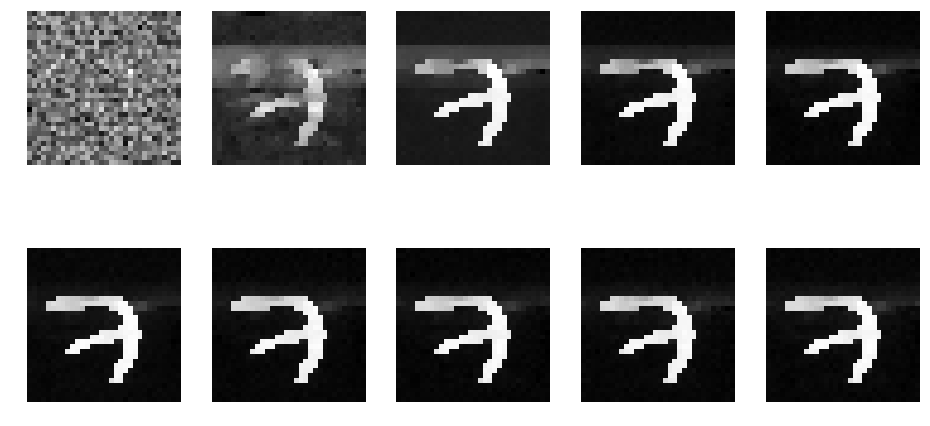

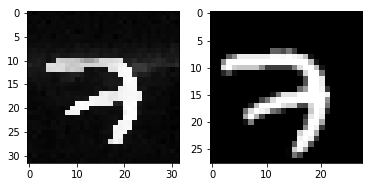

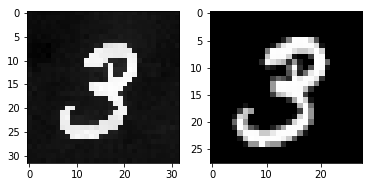

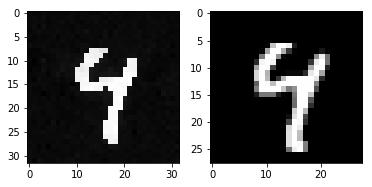

In [34]:
recon = reconstruct(x, 500, coeffs=[1,0,1])  # CS with TV prior

for i in range(3):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(recon[i, :, :, 0], interpolation='nearest', cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mnist.train.images[i].reshape((28,28)), interpolation='nearest', cmap='gray')